In [1]:
import xarray as xr
import numpy as np
import tqdm as tq
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from toolbar.filter import MovingAverageFilter
from toolbar.masked import masked   # 气象工具函数
from toolbar.K_Mean import K_Mean, plot_test

# 数据读取
data_year = ['1961', '2022']
# 读取CN05.1逐日最高气温数据
CN051_1 = xr.open_dataset(r"E:\data\CN05.1\1961_2021\CN05.1_Tmax_1961_2021_daily_025x025.nc")
CN051_2 = xr.open_dataset(r"E:\data\CN05.1\2022\CN05.1_Tmax_2022_daily_025x025.nc")
CN051 = xr.concat([CN051_1, CN051_2], dim='time')
try:
    Tmax_5Day_filt = xr.open_dataarray(fr"D:\PyFile\p2\data\Tmax_5Day_filt.nc")
except:
    Tmax = xr.concat([CN051_1, CN051_2], dim='time')
    Tmax = masked(Tmax, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp")  # 掩膜处理得长江流域温度
    Tmax = Tmax.sel(time=Tmax['time.month'].isin([6, 7, 8])).groupby('time.year')  # 截取夏季数据
    Tmax_5Day_filt = np.array([[[MovingAverageFilter(iyear[1]['tmax'].data[:, i, j], 'lowpass', [5], np.nan).filted() for j in range(283)] for i in range(163)] for iyear in tq.tqdm(Tmax)])  # 5天滑动平均
    Tmax_5Day_filt = Tmax_5Day_filt.transpose(0, 3, 1, 2) # 转换为(year, day, lat, lon)格式
    Tmax_5Day_filt = xr.DataArray(Tmax_5Day_filt,
                                  coords=[[str(i) for i in range(eval(data_year[0]), eval(data_year[1]) + 1)],
                                          [str(i) for i in range(1, 88 + 1)],
                                          CN051_2['lat'].data,
                                          CN051_2['lon'].data],
                                  dims=['year', 'day', 'lat', 'lon'], )
    Tmax_5Day_filt.to_netcdf(fr"D:\PyFile\p2\data\Tmax_5Day_filt.nc")
    del Tmax

zone_stations = masked((CN051_2-CN051_2+1).sel(time='2022-01-01'), r"D:\PyFile\map\self\长江_TP\长江_tp.shp").sum()['tmax'].data
t95 = CN051.quantile(0.95, dim='time')['tmax']

C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\xarray\coding\times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [25]:
EHD = Tmax_5Day_filt - t95

In [57]:
EHD = Tmax_5Day_filt - 35

In [79]:
EHD = EHD.where(EHD > 0, 0)  # 极端高温日温度距平
EHD = EHD.where(EHD == 0, 1)  # 数据二值化处理(1:极端高温, 0:非极端高温)
EHD = masked(EHD, r"D:\PyFile\map\self\长江_TP\长江_tp.shp")  # 掩膜处理得长江流域EHD温度距平
EHDstations_zone = EHD.sum(dim=['lat', 'lon']) / zone_stations  # 长江流域逐日极端高温格点占比
S_th = 0.2
EHD20 = EHD.where(EHDstations_zone >= S_th, np.nan)  # 提取极端高温日占比大于10%
# 获取EHD20的年份和日
EHD20_time = np.zeros((EHD20['year'].size, EHD20['day'].size))
for iyear in range(EHD20['year'].size):
    for iday in range(EHD20['day'].size):
        EHD20_time[iyear, iday] = f"{iyear + 1961}{iday:02d}"

In [80]:
bridge = []
EHD20_time = np.where(EHDstations_zone >= S_th, EHD20_time, np.nan)  # 提取极端高温日占比大于10%
for i in EHD20_time:
    for j in i:
        if not np.isnan(j):
            bridge.append(j)
EHD20_time = np.array(bridge)
EHD20 = masked(EHD20, r"D:\PyFile\map\self\长江_TP\长江_tp.shp")  # 减去非研究地区
EHD20 = EHD20.data.reshape(-1, 163*283)
EHD20 = pd.DataFrame(EHD20).dropna(axis=0, how='all')
EHD20_ = EHD20.dropna(axis=1, how='all')

In [81]:
EHD20_time.shape

(620,)

C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\sklearn\cluster\_kmeans.p

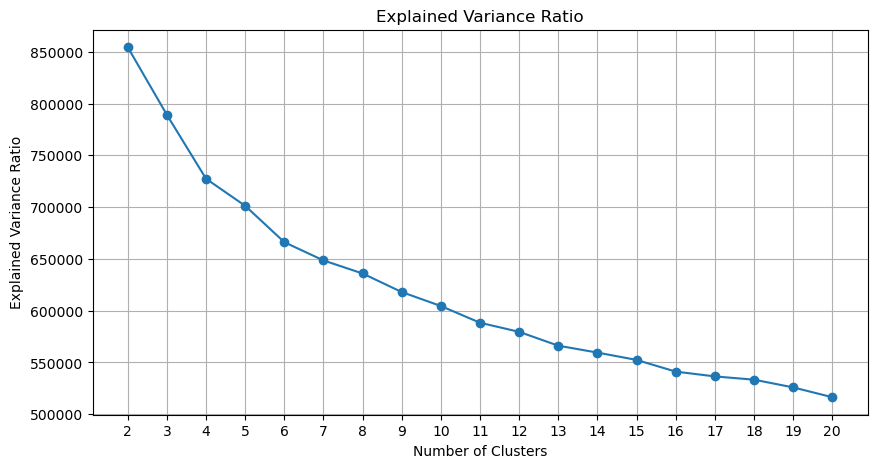

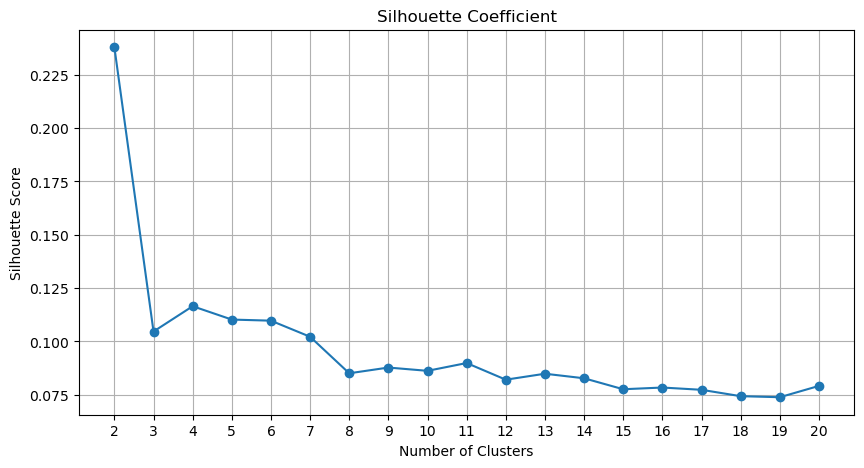

C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\86136\.c

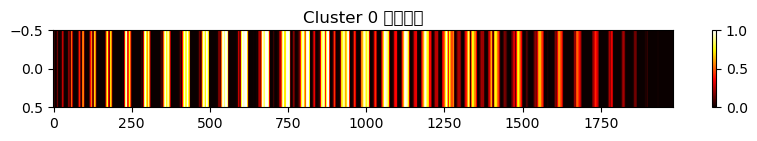

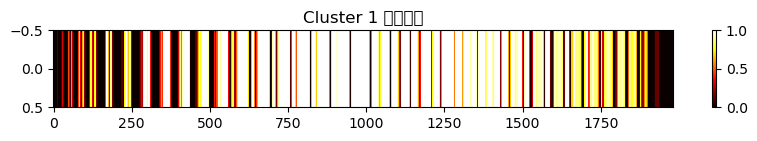

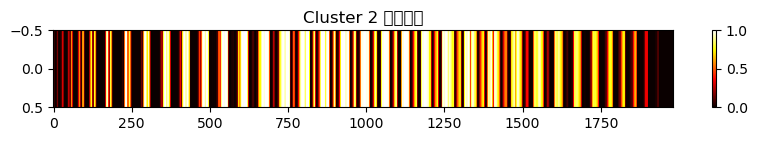

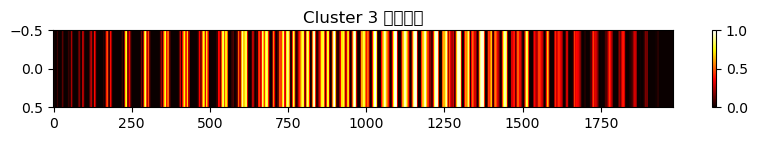

196118.0
196119.0
196140.0
196144.0
196145.0
196179.0
196181.0
196240.0
196246.0
196247.0
196254.0
196255.0
196385.0
196386.0
196387.0
196435.0
196443.0
196444.0
196445.0
196446.0
196447.0
196448.0
196449.0
196654.0
196657.0
196658.0
196659.0
196660.0
196670.0
196671.0
196672.0
196685.0
196686.0
196743.0
196744.0
196745.0
196746.0
196747.0
196766.0
196770.0
196780.0
196781.0
196782.0
196783.0
196856.0
196857.0
196858.0
196859.0
196951.0
196952.0
196953.0
196959.0
197058.0
197059.0
197060.0
197066.0
197067.0
197068.0
197140.0
197154.0
197155.0
197156.0
197157.0
197158.0
197159.0
197234.0
197235.0
197647.0
197648.0
197649.0
197650.0
197651.0
197764.0
197765.0
197829.0
197830.0
197831.0
197832.0
197833.0
197840.0
197841.0
197865.0
197963.0
197964.0
198051.0
198052.0
198053.0
198116.0
198165.0
198166.0
198176.0
198177.0
198178.0
198179.0
198180.0
198359.0
198360.0
198361.0
198362.0
198363.0
198364.0
198365.0
198541.0
198832.0
198833.0
198837.0
198838.0
198842.0
198861.0
198862.0
198863.0
1

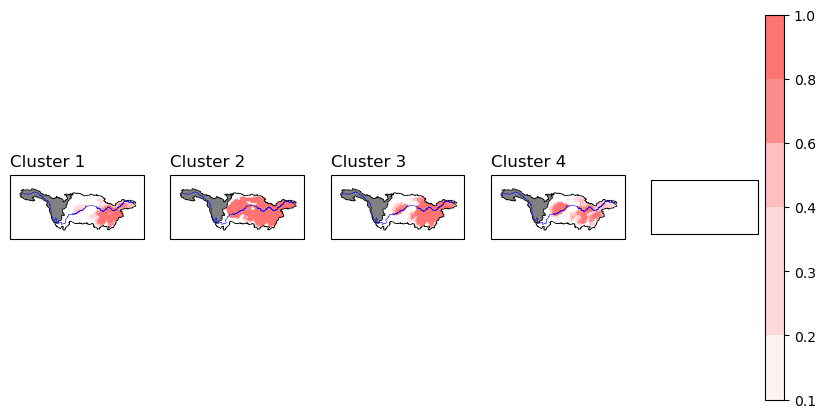

In [83]:
from cartopy.io.shapereader import Reader

plot_test(EHD20_.to_numpy(), max_clusters=20)
K_s = 4
K = K_Mean(EHD20_.to_numpy(), K_s)
import  cmaps
# 绘制三种聚类的平均分布图
fig = plt.figure(figsize=(10, 5))
time = [[] for i in range(K_s)]
for cluster in range(K_s):
    ax = fig.add_subplot(1, K_s+1, cluster+1, projection=ccrs.PlateCarree())
    ax.set_title(f"Cluster {cluster+1}", loc='left')
    ax.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=.5)
    ax.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary2500m_长江流域\TPBoundary2500m_长江流域.shp').geometries(), ccrs.PlateCarree(), facecolor='gray', edgecolor='black', linewidth=.5)
    ax.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江\长江.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', linewidth=0.2)
    ax.set_extent([88, 124, 22, 38])
    KM = []
    for i in K[cluster]['indices']:
        KM.append(EHD20.iloc[i].to_numpy())
        time[cluster].append(str(int(EHD20_time[i])))
        print(EHD20_time[i])
    KM = np.array(KM).mean(axis=0)
    con = ax.contourf(CN051_2['lon'], CN051_2['lat'], KM.reshape(163, 283),
                cmap=cmaps.GMT_polar[10:-4], transform=ccrs.PlateCarree(), levels=[0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1])

    print(f'---{cluster}---'*10)
ax = fig.add_subplot(1, K_s+1, K_s+1, projection=ccrs.PlateCarree())
plt.colorbar(con, ax=ax)
plt.show()

In [85]:
Time_type = np.zeros((62, K_s))
for i in range(K_s):
    for iyear in time[i]:
        index = eval(iyear[:4]) - 1961 # 年份索引
        Time_type[index, i] += 1
Time_type = xr.Dataset({'K':(['year', 'type'], Time_type)},
                       coords={'year': [i for i in range(1961, 2023)], 'type': [i for i in range(1, K_s+1)]})

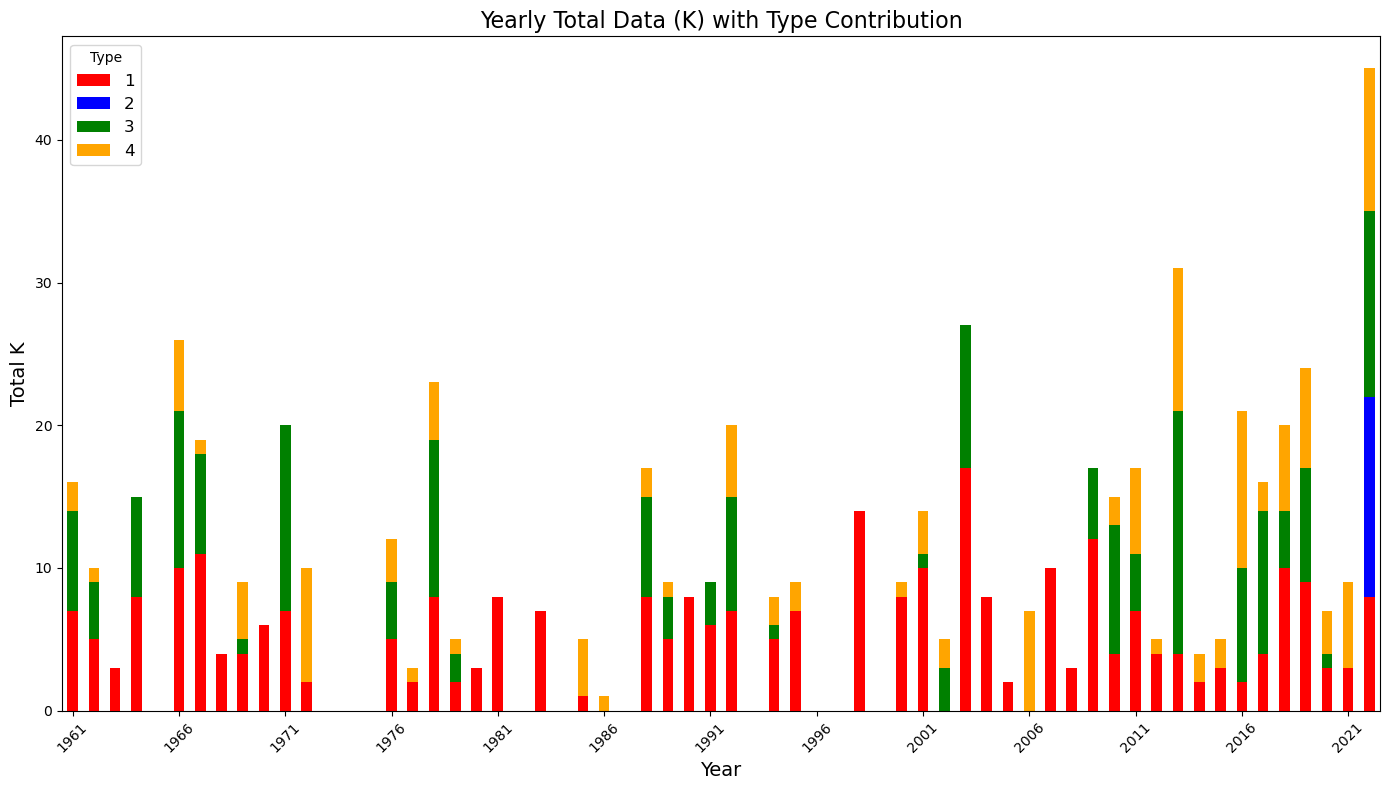

In [86]:
try:
    Time_type.to_netcdf(fr'D:\PyFile\p2\data\Time_type_35_{S_th}_{K_s}.nc')
except:
    pass

# Load the dataset
file_path = fr'D:\PyFile\p2\data\Time_type_35_{S_th}_{K_s}.nc'
data = xr.open_dataset(file_path)

# Convert the dataset to a Pandas DataFrame for easier manipulation
df = data.to_dataframe().reset_index()

# Group by year and type, summing up the values of K
grouped_data = df.groupby(['year', 'type'])['K'].sum().unstack()

# Define contrasting colors for the types
contrasting_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

# Plot the stacked bar chart with adjusted x-axis ticks for every 5th year
grouped_data.plot(kind='bar', stacked=True, figsize=(14, 8), color=contrasting_colors)

# Customize the chart appearance
plt.title('Yearly Total Data (K) with Type Contribution', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total K', fontsize=14)
plt.xticks(ticks=range(0, len(grouped_data), 5), labels=grouped_data.index[::5], rotation=45, fontsize=10)
plt.legend(title='Type', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()
